In [1]:
import pandas as pd
import numpy as np 
import re   ## 抓參數有幾個要用
import scipy.stats as st #計算CI
from sklearn.preprocessing import StandardScaler  #Z-transformation
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set_theme(color_codes=True)

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_score  #5-fold
from sklearn.metrics import f1_score, make_scorer # 改成F1指標看看
from sklearn.model_selection import RepeatedStratifiedKFold #可能可以不用
from sklearn.model_selection import KFold # 不用Repeat(↑)
# KFold(n_splits=2, random_state=None, shuffle=False)

import os  #存模型用的
#from sklearn.externals import joblib #存模型(已棄用)
import joblib
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from xgboost.sklearn import XGBClassifier

from sklearn.metrics import roc_curve, auc  #ROC, AUC
import scikitplot as skplt  #畫 Ensemble的AUC curve
from sklearn.datasets import make_classification  #RandomForestClassifier要用
from sklearn.model_selection import GridSearchCV  ## grid search methods
from sklearn.pipeline import Pipeline #多種算法、模型串起來 (Ensembles時用)
from sklearn.ensemble import VotingClassifier  #後續投票用

C:\ProgramData\Anaconda3\lib\site-packages\dask\dataframe\utils.py:15: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
## 跑ANOVA (多組有沒有顯著差異)
import statsmodels.api as sm  #也求coefficient
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison

In [3]:
##可以順便玩
import imblearn   #平衡類別
from imblearn.over_sampling import RandomOverSampler

In [4]:
## imbalanced-learn 載0.8.1
import sklearn
print(sklearn.__version__)

1.0.1


model.evaluate(Xtrain, Ytrain_onehot) 好像是keras才有的

### Load Data 

In [5]:
datapath = "D:/thesis/OVA_self/141_clinical_data/141_12_163_pre_post/022422_meeting/"

In [6]:
data = pd.read_excel(datapath+"paper_four_training.xlsx")
data

,ID,Age,SMI_cate5,Alb_change,NLR_change,PLR_change
0,870,43,0,-2.272727,-8.854167,-51.275001
1,558,52,0,-2.380952,-57.360197,-48.440942
2,43,55,0,11.764706,-31.677019,-17.345356
3,1037,54,0,13.888889,-16.760829,-52.237065
4,217,46,0,2.380952,-8.087432,32.665735
...,...,...,...,...,...,...
488,652,40,1,-15.000000,-70.202703,-40.194982
489,578,66,1,-10.526316,-39.073227,-55.761137
490,533,58,1,-11.627907,202.816901,203.389227
491,817,54,1,-6.666667,12.012987,-19.689685


#### Target 

In [7]:
#X = data.iloc[:,3:].values  #column: 從第0個到最後一個不挑   ## 我好像只有用到y
y = data.iloc[:,2].values #column: 挑第3個

In [8]:
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

#### 踢掉label 和不要的欄位

In [9]:
## Cell_1要記得砍
final_df_1_drop = data.drop(columns=["ID","SMI_cate5"])

In [10]:
final_df_1_drop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 493 entries, 0 to 492
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Age         493 non-null    int64  
 1   Alb_change  493 non-null    float64
 2   NLR_change  493 non-null    float64
 3   PLR_change  493 non-null    float64
dtypes: float64(3), int64(1)
memory usage: 15.5 KB


### Z transform

In [11]:
# create scaler method 
scaler_z = StandardScaler()

In [12]:
# fit and transform the data
z_data = scaler_z.fit_transform(final_df_1_drop)
z_data

array([[-0.77222209, -0.09371793, -0.12013911, -0.72115332],
       [ 0.04105809, -0.10326069, -0.58981833, -0.67898638],
       [ 0.31215149,  1.14403438, -0.34113059, -0.21632643],
       ...,
       [ 0.58324488, -0.91861199,  1.92945142,  3.06790346],
       [ 0.22178702, -0.48115405,  0.08191552, -0.25120686],
       [ 0.13142256, -1.08487557, -0.10319881,  0.28530964]])

In [13]:
pd_z_data = pd.DataFrame(z_data, columns = final_df_1_drop.columns)
pd_z_data

,Age,Alb_change,NLR_change,PLR_change
0,-0.772222,-0.093718,-0.120139,-0.721153
1,0.041058,-0.103261,-0.589818,-0.678986
2,0.312151,1.144034,-0.341131,-0.216326
3,0.221787,1.331334,-0.196699,-0.735468
4,-0.501129,0.316621,-0.112715,0.527770
...,...,...,...,...
488,-1.043315,-1.215947,-0.714171,-0.556298
489,1.306161,-0.821479,-0.412747,-0.787901
490,0.583245,-0.918612,1.929451,3.067903
491,0.221787,-0.481154,0.081916,-0.251207


### RandomOverSampler

In [14]:
data["SMI_cate5"].value_counts()

0    331
1    162
Name: SMI_cate5, dtype: int64

<AxesSubplot:>

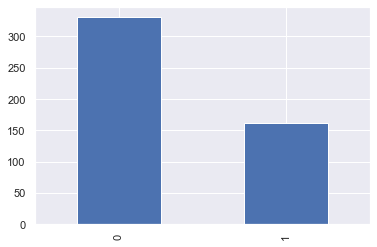

In [15]:
data["SMI_cate5"].value_counts().plot(kind="bar")

#### Metrics 

In [16]:
#f1 = make_scorer(f1_score , average='micro')

In [17]:
## 如果單獨兩個model分開的話:
#### 在LR_0510那裡測試，不管有沒有加 random_state或probability，數值都不變，所以直接用預設的就好了

## 但如果是Ensemble的話，SVC需要把probability = True
### 預防起見，random_state設成0 (即便有沒有設都一樣)
# model1_1 = LogisticRegression(random_state=0)
# model1_2 = SVC(probability=True,random_state=0)

In [18]:
model1_1 = LogisticRegression()
model1_2 = SVC(probability=True,random_state=0)
eclf1 = VotingClassifier(estimators = [('logistic',model1_1),('svm',model1_2)],
                        voting = 'soft')

### 1、500 Bootstrap

In [19]:
save_datapath_report = "D:/thesis/論文收尾/Results_Wu_051022/500_Bootstrap/500_outcome/500_outcome_Ensemble/"

precision_ans_ov_rf = []
sensitivity_ans_ov_rf = []
specificity_ans_ov_rf = []
F1_ans_ov_rf = []
accuracy_ans_ov_rf = []
auc_ans_ov_rf = []

for i in range(500):  ####
    print("Random_state :", i)
    X_train, X_test, Y_train, Y_test = train_test_split(pd_z_data, y, test_size = 0.3, random_state=i)
    
    over = RandomOverSampler(sampling_strategy='auto', random_state = 1)
    X_smote, y_smote = over.fit_resample(X_train, Y_train)
    
    #改這裡 (Oversample之後)
    #classifier_lr.fit(X_train, Y_train)
    eclf1.fit(X_smote, y_smote)
    print('label = 1:',sum(y_smote))
    print('label = 0:',len(y_smote) - sum(y_smote))
    print('before balance label = 1:',sum(Y_train))
    print('before balance label = 0:',len(Y_train) - sum(Y_train))
    
    predicted_rf = eclf1.predict(X_test)
    print(metrics.classification_report(Y_test, predicted_rf))
    
    #500 Overcome
    K_rf = metrics.classification_report(Y_test, predicted_rf,output_dict=True) ###
    df_rf = pd.DataFrame(K_rf).transpose()
    df_rf.to_csv(save_datapath_report+str(i)+"_Ensemble_report.csv")
    
    Pre_rf = metrics.precision_score(Y_test, predicted_rf)
    print('Precision_predict:',Pre_rf)
    Sen_rf = metrics.recall_score(Y_test, predicted_rf)
    print('Sensitivity_predict:',Sen_rf)
    Spe_rf = metrics.recall_score(Y_test, predicted_rf, pos_label=0)
    print('Specificity_predict:',Spe_rf)
    F1_rf = metrics.f1_score(Y_test, predicted_rf)
    print('F1_predict:',F1_rf)
    Acc_rf = metrics.accuracy_score(Y_test, predicted_rf)
    print('accuracy_predict:',Acc_rf)
    auc_rf = metrics.roc_auc_score(Y_test, predicted_rf, average='macro')
    print('auc_predict:',auc_rf,"\n")
    
    precision_ans_ov_rf.append(Pre_rf)
    sensitivity_ans_ov_rf.append(Sen_rf)
    specificity_ans_ov_rf.append(Spe_rf)
    F1_ans_ov_rf.append(F1_rf)
    accuracy_ans_ov_rf.append(Acc_rf)
    auc_ans_ov_rf.append(auc_rf)

Random_state : 0
label = 1: 232
label = 0: 232
before balance label = 1: 113
before balance label = 0: 232
              precision    recall  f1-score   support

           0       0.88      0.80      0.84        99
           1       0.66      0.78      0.71        49

    accuracy                           0.79       148
   macro avg       0.77      0.79      0.77       148
weighted avg       0.80      0.79      0.79       148

Precision_predict: 0.6551724137931034
Sensitivity_predict: 0.7755102040816326
Specificity_predict: 0.797979797979798
F1_predict: 0.7102803738317757
accuracy_predict: 0.7905405405405406
auc_predict: 0.7867450010307153 

Random_state : 1
label = 1: 232
label = 0: 232
before balance label = 1: 113
before balance label = 0: 232
              precision    recall  f1-score   support

           0       0.91      0.85      0.88        99
           1       0.73      0.84      0.78        49

    accuracy                           0.84       148
   macro avg       0.8

              precision    recall  f1-score   support

           0       0.87      0.87      0.87        99
           1       0.73      0.73      0.73        49

    accuracy                           0.82       148
   macro avg       0.80      0.80      0.80       148
weighted avg       0.82      0.82      0.82       148

Precision_predict: 0.7346938775510204
Sensitivity_predict: 0.7346938775510204
Specificity_predict: 0.8686868686868687
F1_predict: 0.7346938775510203
accuracy_predict: 0.8243243243243243
auc_predict: 0.8016903731189446 

Random_state : 15
label = 1: 228
label = 0: 228
before balance label = 1: 117
before balance label = 0: 228
              precision    recall  f1-score   support

           0       0.95      0.83      0.89       103
           1       0.70      0.89      0.78        45

    accuracy                           0.85       148
   macro avg       0.82      0.86      0.84       148
weighted avg       0.87      0.85      0.86       148

Precision_predict:

label = 1: 232
label = 0: 232
before balance label = 1: 113
before balance label = 0: 232
              precision    recall  f1-score   support

           0       0.89      0.84      0.86        99
           1       0.71      0.80      0.75        49

    accuracy                           0.82       148
   macro avg       0.80      0.82      0.81       148
weighted avg       0.83      0.82      0.83       148

Precision_predict: 0.7090909090909091
Sensitivity_predict: 0.7959183673469388
Specificity_predict: 0.8383838383838383
F1_predict: 0.75
accuracy_predict: 0.8243243243243243
auc_predict: 0.8171511028653885 

Random_state : 29
label = 1: 225
label = 0: 225
before balance label = 1: 120
before balance label = 0: 225
              precision    recall  f1-score   support

           0       0.88      0.86      0.87       106
           1       0.67      0.71      0.69        42

    accuracy                           0.82       148
   macro avg       0.78      0.79      0.78       1

Precision_predict: 0.7222222222222222
Sensitivity_predict: 0.7647058823529411
Specificity_predict: 0.845360824742268
F1_predict: 0.7428571428571428
accuracy_predict: 0.8175675675675675
auc_predict: 0.8050333535476046 

Random_state : 42
label = 1: 234
label = 0: 234
before balance label = 1: 111
before balance label = 0: 234
              precision    recall  f1-score   support

           0       0.88      0.78      0.83        97
           1       0.66      0.80      0.73        51

    accuracy                           0.79       148
   macro avg       0.77      0.79      0.78       148
weighted avg       0.81      0.79      0.79       148

Precision_predict: 0.6612903225806451
Sensitivity_predict: 0.803921568627451
Specificity_predict: 0.7835051546391752
F1_predict: 0.7256637168141592
accuracy_predict: 0.7905405405405406
auc_predict: 0.7937133616333132 

Random_state : 43
label = 1: 233
label = 0: 233
before balance label = 1: 112
before balance label = 0: 233
              preci

label = 1: 225
label = 0: 225
before balance label = 1: 120
before balance label = 0: 225
              precision    recall  f1-score   support

           0       0.92      0.85      0.88       106
           1       0.68      0.81      0.74        42

    accuracy                           0.84       148
   macro avg       0.80      0.83      0.81       148
weighted avg       0.85      0.84      0.84       148

Precision_predict: 0.68
Sensitivity_predict: 0.8095238095238095
Specificity_predict: 0.8490566037735849
F1_predict: 0.7391304347826089
accuracy_predict: 0.8378378378378378
auc_predict: 0.8292902066486972 

Random_state : 57
label = 1: 238
label = 0: 238
before balance label = 1: 107
before balance label = 0: 238
              precision    recall  f1-score   support

           0       0.87      0.83      0.85        93
           1       0.73      0.78      0.75        55

    accuracy                           0.81       148
   macro avg       0.80      0.80      0.80       1

label = 1: 230
label = 0: 230
before balance label = 1: 115
before balance label = 0: 230
              precision    recall  f1-score   support

           0       0.88      0.84      0.86       101
           1       0.69      0.74      0.71        47

    accuracy                           0.81       148
   macro avg       0.78      0.79      0.79       148
weighted avg       0.82      0.81      0.81       148

Precision_predict: 0.6862745098039216
Sensitivity_predict: 0.7446808510638298
Specificity_predict: 0.8415841584158416
F1_predict: 0.7142857142857144
accuracy_predict: 0.8108108108108109
auc_predict: 0.7931325047398357 

Random_state : 72
label = 1: 224
label = 0: 224
before balance label = 1: 121
before balance label = 0: 224
              precision    recall  f1-score   support

           0       0.94      0.81      0.87       107
           1       0.64      0.85      0.73        41

    accuracy                           0.82       148
   macro avg       0.79      0.83    

              precision    recall  f1-score   support

           0       0.86      0.81      0.83        99
           1       0.65      0.73      0.69        49

    accuracy                           0.78       148
   macro avg       0.76      0.77      0.76       148
weighted avg       0.79      0.78      0.79       148

Precision_predict: 0.6545454545454545
Sensitivity_predict: 0.7346938775510204
Specificity_predict: 0.8080808080808081
F1_predict: 0.6923076923076923
accuracy_predict: 0.7837837837837838
auc_predict: 0.7713873428159143 

Random_state : 87
label = 1: 228
label = 0: 228
before balance label = 1: 117
before balance label = 0: 228
              precision    recall  f1-score   support

           0       0.89      0.83      0.86       103
           1       0.67      0.76      0.71        45

    accuracy                           0.81       148
   macro avg       0.78      0.80      0.78       148
weighted avg       0.82      0.81      0.81       148

Precision_predict:

Precision_predict: 0.6071428571428571
Sensitivity_predict: 0.7906976744186046
Specificity_predict: 0.7904761904761904
F1_predict: 0.6868686868686869
accuracy_predict: 0.7905405405405406
auc_predict: 0.7905869324473975 

Random_state : 102
label = 1: 231
label = 0: 231
before balance label = 1: 114
before balance label = 0: 231
              precision    recall  f1-score   support

           0       0.89      0.89      0.89       100
           1       0.77      0.77      0.77        48

    accuracy                           0.85       148
   macro avg       0.83      0.83      0.83       148
weighted avg       0.85      0.85      0.85       148

Precision_predict: 0.7708333333333334
Sensitivity_predict: 0.7708333333333334
Specificity_predict: 0.89
F1_predict: 0.7708333333333333
accuracy_predict: 0.8513513513513513
auc_predict: 0.8304166666666667 

Random_state : 103
label = 1: 233
label = 0: 233
before balance label = 1: 112
before balance label = 0: 233
              precision    re

label = 0: 233
before balance label = 1: 112
before balance label = 0: 233
              precision    recall  f1-score   support

           0       0.86      0.77      0.81        98
           1       0.62      0.76      0.68        50

    accuracy                           0.76       148
   macro avg       0.74      0.76      0.75       148
weighted avg       0.78      0.76      0.77       148

Precision_predict: 0.6229508196721312
Sensitivity_predict: 0.76
Specificity_predict: 0.7653061224489796
F1_predict: 0.6846846846846847
accuracy_predict: 0.7635135135135135
auc_predict: 0.7626530612244897 

Random_state : 117
label = 1: 226
label = 0: 226
before balance label = 1: 119
before balance label = 0: 226
              precision    recall  f1-score   support

           0       0.86      0.81      0.83       105
           1       0.59      0.67      0.63        43

    accuracy                           0.77       148
   macro avg       0.73      0.74      0.73       148
weighted av

label = 1: 236
label = 0: 236
before balance label = 1: 109
before balance label = 0: 236
              precision    recall  f1-score   support

           0       0.86      0.87      0.86        95
           1       0.76      0.74      0.75        53

    accuracy                           0.82       148
   macro avg       0.81      0.80      0.81       148
weighted avg       0.82      0.82      0.82       148

Precision_predict: 0.7647058823529411
Sensitivity_predict: 0.7358490566037735
Specificity_predict: 0.8736842105263158
F1_predict: 0.7499999999999999
accuracy_predict: 0.8243243243243243
auc_predict: 0.8047666335650449 

Random_state : 132
label = 1: 237
label = 0: 237
before balance label = 1: 108
before balance label = 0: 237
              precision    recall  f1-score   support

           0       0.92      0.86      0.89        94
           1       0.78      0.87      0.82        54

    accuracy                           0.86       148
   macro avg       0.85      0.87   

label = 1: 233
label = 0: 233
before balance label = 1: 112
before balance label = 0: 233
              precision    recall  f1-score   support

           0       0.88      0.90      0.89        98
           1       0.79      0.76      0.78        50

    accuracy                           0.85       148
   macro avg       0.84      0.83      0.83       148
weighted avg       0.85      0.85      0.85       148

Precision_predict: 0.7916666666666666
Sensitivity_predict: 0.76
Specificity_predict: 0.8979591836734694
F1_predict: 0.7755102040816326
accuracy_predict: 0.8513513513513513
auc_predict: 0.8289795918367348 

Random_state : 147
label = 1: 225
label = 0: 225
before balance label = 1: 120
before balance label = 0: 225
              precision    recall  f1-score   support

           0       0.86      0.77      0.82       106
           1       0.55      0.69      0.61        42

    accuracy                           0.75       148
   macro avg       0.71      0.73      0.71       

label = 1: 230
label = 0: 230
before balance label = 1: 115
before balance label = 0: 230
              precision    recall  f1-score   support

           0       0.86      0.83      0.84       101
           1       0.66      0.70      0.68        47

    accuracy                           0.79       148
   macro avg       0.76      0.77      0.76       148
weighted avg       0.79      0.79      0.79       148

Precision_predict: 0.66
Sensitivity_predict: 0.7021276595744681
Specificity_predict: 0.8316831683168316
F1_predict: 0.6804123711340208
accuracy_predict: 0.7905405405405406
auc_predict: 0.7669054139456498 

Random_state : 161
label = 1: 237
label = 0: 237
before balance label = 1: 108
before balance label = 0: 237
              precision    recall  f1-score   support

           0       0.89      0.83      0.86        94
           1       0.73      0.81      0.77        54

    accuracy                           0.82       148
   macro avg       0.81      0.82      0.81       

              precision    recall  f1-score   support

           0       0.90      0.79      0.84        96
           1       0.69      0.85      0.76        52

    accuracy                           0.81       148
   macro avg       0.80      0.82      0.80       148
weighted avg       0.83      0.81      0.81       148

Precision_predict: 0.6875
Sensitivity_predict: 0.8461538461538461
Specificity_predict: 0.7916666666666666
F1_predict: 0.7586206896551724
accuracy_predict: 0.8108108108108109
auc_predict: 0.8189102564102564 

Random_state : 174
label = 1: 234
label = 0: 234
before balance label = 1: 111
before balance label = 0: 234
              precision    recall  f1-score   support

           0       0.92      0.78      0.84        97
           1       0.68      0.86      0.76        51

    accuracy                           0.81       148
   macro avg       0.80      0.82      0.80       148
weighted avg       0.83      0.81      0.81       148

Precision_predict: 0.67692307

              precision    recall  f1-score   support

           0       0.88      0.84      0.86       100
           1       0.70      0.77      0.73        48

    accuracy                           0.82       148
   macro avg       0.79      0.81      0.80       148
weighted avg       0.82      0.82      0.82       148

Precision_predict: 0.6981132075471698
Sensitivity_predict: 0.7708333333333334
Specificity_predict: 0.84
F1_predict: 0.7326732673267327
accuracy_predict: 0.8175675675675675
auc_predict: 0.8054166666666667 

Random_state : 188
label = 1: 232
label = 0: 232
before balance label = 1: 113
before balance label = 0: 232
              precision    recall  f1-score   support

           0       0.88      0.85      0.87        99
           1       0.72      0.78      0.75        49

    accuracy                           0.82       148
   macro avg       0.80      0.81      0.81       148
weighted avg       0.83      0.82      0.83       148

Precision_predict: 0.7169811320

label = 1: 225
label = 0: 225
before balance label = 1: 120
before balance label = 0: 225
              precision    recall  f1-score   support

           0       0.93      0.80      0.86       106
           1       0.63      0.86      0.73        42

    accuracy                           0.82       148
   macro avg       0.78      0.83      0.80       148
weighted avg       0.85      0.82      0.82       148

Precision_predict: 0.631578947368421
Sensitivity_predict: 0.8571428571428571
Specificity_predict: 0.8018867924528302
F1_predict: 0.7272727272727273
accuracy_predict: 0.8175675675675675
auc_predict: 0.8295148247978437 

Random_state : 203
label = 1: 224
label = 0: 224
before balance label = 1: 121
before balance label = 0: 224
              precision    recall  f1-score   support

           0       0.92      0.71      0.80       107
           1       0.52      0.83      0.64        41

    accuracy                           0.74       148
   macro avg       0.72      0.77    

label = 1: 229
label = 0: 229
before balance label = 1: 116
before balance label = 0: 229
              precision    recall  f1-score   support

           0       0.92      0.80      0.86       102
           1       0.66      0.85      0.74        46

    accuracy                           0.82       148
   macro avg       0.79      0.83      0.80       148
weighted avg       0.84      0.82      0.82       148

Precision_predict: 0.6610169491525424
Sensitivity_predict: 0.8478260869565217
Specificity_predict: 0.803921568627451
F1_predict: 0.7428571428571429
accuracy_predict: 0.8175675675675675
auc_predict: 0.8258738277919865 

Random_state : 218
label = 1: 232
label = 0: 232
before balance label = 1: 113
before balance label = 0: 232
              precision    recall  f1-score   support

           0       0.83      0.76      0.79        99
           1       0.59      0.69      0.64        49

    accuracy                           0.74       148
   macro avg       0.71      0.73    

label = 1: 236
label = 0: 236
before balance label = 1: 109
before balance label = 0: 236
              precision    recall  f1-score   support

           0       0.88      0.83      0.85        95
           1       0.72      0.79      0.76        53

    accuracy                           0.82       148
   macro avg       0.80      0.81      0.81       148
weighted avg       0.82      0.82      0.82       148

Precision_predict: 0.7241379310344828
Sensitivity_predict: 0.7924528301886793
Specificity_predict: 0.8315789473684211
F1_predict: 0.7567567567567567
accuracy_predict: 0.8175675675675675
auc_predict: 0.8120158887785502 

Random_state : 233
label = 1: 233
label = 0: 233
before balance label = 1: 112
before balance label = 0: 233
              precision    recall  f1-score   support

           0       0.90      0.78      0.84        98
           1       0.66      0.84      0.74        50

    accuracy                           0.80       148
   macro avg       0.78      0.81   

              precision    recall  f1-score   support

           0       0.89      0.80      0.84        99
           1       0.66      0.80      0.72        49

    accuracy                           0.80       148
   macro avg       0.77      0.80      0.78       148
weighted avg       0.81      0.80      0.80       148

Precision_predict: 0.6610169491525424
Sensitivity_predict: 0.7959183673469388
Specificity_predict: 0.797979797979798
F1_predict: 0.7222222222222222
accuracy_predict: 0.7972972972972973
auc_predict: 0.7969490826633684 

Random_state : 247
label = 1: 229
label = 0: 229
before balance label = 1: 116
before balance label = 0: 229
              precision    recall  f1-score   support

           0       0.88      0.83      0.85       102
           1       0.67      0.74      0.70        46

    accuracy                           0.80       148
   macro avg       0.77      0.79      0.78       148
weighted avg       0.81      0.80      0.81       148

Precision_predict:

              precision    recall  f1-score   support

           0       0.83      0.84      0.83        97
           1       0.68      0.67      0.67        51

    accuracy                           0.78       148
   macro avg       0.75      0.75      0.75       148
weighted avg       0.78      0.78      0.78       148

Precision_predict: 0.68
Sensitivity_predict: 0.6666666666666666
Specificity_predict: 0.8350515463917526
F1_predict: 0.6732673267326733
accuracy_predict: 0.777027027027027
auc_predict: 0.7508591065292096 

Random_state : 262
label = 1: 231
label = 0: 231
before balance label = 1: 114
before balance label = 0: 231
              precision    recall  f1-score   support

           0       0.88      0.85      0.86       100
           1       0.71      0.75      0.73        48

    accuracy                           0.82       148
   macro avg       0.79      0.80      0.80       148
weighted avg       0.82      0.82      0.82       148

Precision_predict: 0.70588235294

label = 1: 235
label = 0: 235
before balance label = 1: 110
before balance label = 0: 235
              precision    recall  f1-score   support

           0       0.87      0.84      0.86        96
           1       0.73      0.77      0.75        52

    accuracy                           0.82       148
   macro avg       0.80      0.81      0.80       148
weighted avg       0.82      0.82      0.82       148

Precision_predict: 0.7272727272727273
Sensitivity_predict: 0.7692307692307693
Specificity_predict: 0.84375
F1_predict: 0.7476635514018691
accuracy_predict: 0.8175675675675675
auc_predict: 0.8064903846153846 

Random_state : 277
label = 1: 225
label = 0: 225
before balance label = 1: 120
before balance label = 0: 225
              precision    recall  f1-score   support

           0       0.90      0.80      0.85       106
           1       0.61      0.79      0.69        42

    accuracy                           0.80       148
   macro avg       0.76      0.79      0.77    

label = 1: 223
label = 0: 223
before balance label = 1: 122
before balance label = 0: 223
              precision    recall  f1-score   support

           0       0.93      0.82      0.87       108
           1       0.63      0.82      0.72        40

    accuracy                           0.82       148
   macro avg       0.78      0.82      0.79       148
weighted avg       0.85      0.82      0.83       148

Precision_predict: 0.6346153846153846
Sensitivity_predict: 0.825
Specificity_predict: 0.8240740740740741
F1_predict: 0.717391304347826
accuracy_predict: 0.8243243243243243
auc_predict: 0.8245370370370371 

Random_state : 292
label = 1: 230
label = 0: 230
before balance label = 1: 115
before balance label = 0: 230
              precision    recall  f1-score   support

           0       0.89      0.85      0.87       101
           1       0.71      0.77      0.73        47

    accuracy                           0.82       148
   macro avg       0.80      0.81      0.80       

label = 1: 230
label = 0: 230
before balance label = 1: 115
before balance label = 0: 230
              precision    recall  f1-score   support

           0       0.88      0.87      0.88       101
           1       0.73      0.74      0.74        47

    accuracy                           0.83       148
   macro avg       0.80      0.81      0.81       148
weighted avg       0.83      0.83      0.83       148

Precision_predict: 0.7291666666666666
Sensitivity_predict: 0.7446808510638298
Specificity_predict: 0.8712871287128713
F1_predict: 0.7368421052631579
accuracy_predict: 0.831081081081081
auc_predict: 0.8079839898883506 

Random_state : 307
label = 1: 237
label = 0: 237
before balance label = 1: 108
before balance label = 0: 237
              precision    recall  f1-score   support

           0       0.87      0.84      0.85        94
           1       0.74      0.78      0.76        54

    accuracy                           0.82       148
   macro avg       0.80      0.81    

label = 1: 232
label = 0: 232
before balance label = 1: 113
before balance label = 0: 232
              precision    recall  f1-score   support

           0       0.90      0.83      0.86        99
           1       0.70      0.82      0.75        49

    accuracy                           0.82       148
   macro avg       0.80      0.82      0.81       148
weighted avg       0.84      0.82      0.83       148

Precision_predict: 0.7017543859649122
Sensitivity_predict: 0.8163265306122449
Specificity_predict: 0.8282828282828283
F1_predict: 0.7547169811320754
accuracy_predict: 0.8243243243243243
auc_predict: 0.8223046794475366 

Random_state : 321
label = 1: 234
label = 0: 234
before balance label = 1: 111
before balance label = 0: 234
              precision    recall  f1-score   support

           0       0.85      0.92      0.88        97
           1       0.81      0.69      0.74        51

    accuracy                           0.84       148
   macro avg       0.83      0.80   

              precision    recall  f1-score   support

           0       0.90      0.77      0.83       100
           1       0.63      0.81      0.71        48

    accuracy                           0.78       148
   macro avg       0.76      0.79      0.77       148
weighted avg       0.81      0.78      0.79       148

Precision_predict: 0.6290322580645161
Sensitivity_predict: 0.8125
Specificity_predict: 0.77
F1_predict: 0.7090909090909092
accuracy_predict: 0.7837837837837838
auc_predict: 0.79125 

Random_state : 336
label = 1: 230
label = 0: 230
before balance label = 1: 115
before balance label = 0: 230
              precision    recall  f1-score   support

           0       0.86      0.87      0.87       101
           1       0.72      0.70      0.71        47

    accuracy                           0.82       148
   macro avg       0.79      0.79      0.79       148
weighted avg       0.82      0.82      0.82       148

Precision_predict: 0.717391304347826
Sensitivity_predi

              precision    recall  f1-score   support

           0       0.85      0.81      0.83       101
           1       0.63      0.70      0.67        47

    accuracy                           0.78       148
   macro avg       0.74      0.76      0.75       148
weighted avg       0.78      0.78      0.78       148

Precision_predict: 0.6346153846153846
Sensitivity_predict: 0.7021276595744681
Specificity_predict: 0.8118811881188119
F1_predict: 0.6666666666666666
accuracy_predict: 0.777027027027027
auc_predict: 0.75700442384664 

Random_state : 351
label = 1: 242
label = 0: 242
before balance label = 1: 103
before balance label = 0: 242
              precision    recall  f1-score   support

           0       0.86      0.90      0.88        89
           1       0.84      0.78      0.81        59

    accuracy                           0.85       148
   macro avg       0.85      0.84      0.84       148
weighted avg       0.85      0.85      0.85       148

Precision_predict: 0

auc_predict: 0.7824074074074074 

Random_state : 363
label = 1: 221
label = 0: 221
before balance label = 1: 124
before balance label = 0: 221
              precision    recall  f1-score   support

           0       0.92      0.85      0.89       110
           1       0.65      0.79      0.71        38

    accuracy                           0.84       148
   macro avg       0.79      0.82      0.80       148
weighted avg       0.85      0.84      0.84       148

Precision_predict: 0.6521739130434783
Sensitivity_predict: 0.7894736842105263
Specificity_predict: 0.8545454545454545
F1_predict: 0.7142857142857143
accuracy_predict: 0.8378378378378378
auc_predict: 0.8220095693779904 

Random_state : 364
label = 1: 234
label = 0: 234
before balance label = 1: 111
before balance label = 0: 234
              precision    recall  f1-score   support

           0       0.87      0.88      0.87        97
           1       0.76      0.75      0.75        51

    accuracy                         

              precision    recall  f1-score   support

           0       0.88      0.88      0.88        96
           1       0.77      0.79      0.78        52

    accuracy                           0.84       148
   macro avg       0.83      0.83      0.83       148
weighted avg       0.85      0.84      0.84       148

Precision_predict: 0.7735849056603774
Sensitivity_predict: 0.7884615384615384
Specificity_predict: 0.875
F1_predict: 0.780952380952381
accuracy_predict: 0.8445945945945946
auc_predict: 0.8317307692307692 

Random_state : 378
label = 1: 235
label = 0: 235
before balance label = 1: 110
before balance label = 0: 235
              precision    recall  f1-score   support

           0       0.87      0.86      0.87        96
           1       0.75      0.77      0.76        52

    accuracy                           0.83       148
   macro avg       0.81      0.82      0.82       148
weighted avg       0.83      0.83      0.83       148

Precision_predict: 0.7547169811

Specificity_predict: 0.8557692307692307
F1_predict: 0.7311827956989247
accuracy_predict: 0.831081081081081
auc_predict: 0.8142482517482518 

Random_state : 390
label = 1: 241
label = 0: 241
before balance label = 1: 104
before balance label = 0: 241
              precision    recall  f1-score   support

           0       0.83      0.77      0.80        90
           1       0.68      0.76      0.72        58

    accuracy                           0.76       148
   macro avg       0.75      0.76      0.76       148
weighted avg       0.77      0.76      0.77       148

Precision_predict: 0.676923076923077
Sensitivity_predict: 0.7586206896551724
Specificity_predict: 0.7666666666666667
F1_predict: 0.7154471544715447
accuracy_predict: 0.7635135135135135
auc_predict: 0.7626436781609195 

Random_state : 391
label = 1: 239
label = 0: 239
before balance label = 1: 106
before balance label = 0: 239
              precision    recall  f1-score   support

           0       0.88      0.88      0

auc_predict: 0.8629166666666667 

Random_state : 404
label = 1: 228
label = 0: 228
before balance label = 1: 117
before balance label = 0: 228
              precision    recall  f1-score   support

           0       0.93      0.85      0.89       103
           1       0.72      0.84      0.78        45

    accuracy                           0.85       148
   macro avg       0.82      0.85      0.83       148
weighted avg       0.86      0.85      0.85       148

Precision_predict: 0.7169811320754716
Sensitivity_predict: 0.8444444444444444
Specificity_predict: 0.8543689320388349
F1_predict: 0.7755102040816326
accuracy_predict: 0.8513513513513513
auc_predict: 0.8494066882416399 

Random_state : 405
label = 1: 228
label = 0: 228
before balance label = 1: 117
before balance label = 0: 228
              precision    recall  f1-score   support

           0       0.92      0.88      0.90       103
           1       0.76      0.82      0.79        45

    accuracy                         

              precision    recall  f1-score   support

           0       0.90      0.80      0.85       102
           1       0.65      0.80      0.72        46

    accuracy                           0.80       148
   macro avg       0.78      0.80      0.78       148
weighted avg       0.82      0.80      0.81       148

Precision_predict: 0.6491228070175439
Sensitivity_predict: 0.8043478260869565
Specificity_predict: 0.803921568627451
F1_predict: 0.7184466019417476
accuracy_predict: 0.8040540540540541
auc_predict: 0.8041346973572038 

Random_state : 418
label = 1: 238
label = 0: 238
before balance label = 1: 107
before balance label = 0: 238
              precision    recall  f1-score   support

           0       0.90      0.80      0.85        93
           1       0.71      0.85      0.78        55

    accuracy                           0.82       148
   macro avg       0.81      0.83      0.81       148
weighted avg       0.83      0.82      0.82       148

Precision_predict:

              precision    recall  f1-score   support

           0       0.87      0.84      0.86       102
           1       0.67      0.72      0.69        46

    accuracy                           0.80       148
   macro avg       0.77      0.78      0.78       148
weighted avg       0.81      0.80      0.81       148

Precision_predict: 0.673469387755102
Sensitivity_predict: 0.717391304347826
Specificity_predict: 0.8431372549019608
F1_predict: 0.6947368421052631
accuracy_predict: 0.8040540540540541
auc_predict: 0.7802642796248934 

Random_state : 433
label = 1: 230
label = 0: 230
before balance label = 1: 115
before balance label = 0: 230
              precision    recall  f1-score   support

           0       0.89      0.80      0.84       101
           1       0.65      0.79      0.71        47

    accuracy                           0.80       148
   macro avg       0.77      0.79      0.78       148
weighted avg       0.81      0.80      0.80       148

Precision_predict: 

before balance label = 1: 114
before balance label = 0: 231
              precision    recall  f1-score   support

           0       0.87      0.87      0.87       100
           1       0.73      0.73      0.73        48

    accuracy                           0.82       148
   macro avg       0.80      0.80      0.80       148
weighted avg       0.82      0.82      0.82       148

Precision_predict: 0.7291666666666666
Sensitivity_predict: 0.7291666666666666
Specificity_predict: 0.87
F1_predict: 0.7291666666666665
accuracy_predict: 0.8243243243243243
auc_predict: 0.7995833333333332 

Random_state : 448
label = 1: 236
label = 0: 236
before balance label = 1: 109
before balance label = 0: 236
              precision    recall  f1-score   support

           0       0.90      0.85      0.88        95
           1       0.76      0.83      0.79        53

    accuracy                           0.84       148
   macro avg       0.83      0.84      0.83       148
weighted avg       0.85   

label = 0: 232
before balance label = 1: 113
before balance label = 0: 232
              precision    recall  f1-score   support

           0       0.87      0.85      0.86        99
           1       0.71      0.73      0.72        49

    accuracy                           0.81       148
   macro avg       0.79      0.79      0.79       148
weighted avg       0.81      0.81      0.81       148

Precision_predict: 0.7058823529411765
Sensitivity_predict: 0.7346938775510204
Specificity_predict: 0.8484848484848485
F1_predict: 0.7200000000000001
accuracy_predict: 0.8108108108108109
auc_predict: 0.7915893630179344 

Random_state : 462
label = 1: 233
label = 0: 233
before balance label = 1: 112
before balance label = 0: 233
              precision    recall  f1-score   support

           0       0.83      0.74      0.78        98
           1       0.58      0.70      0.64        50

    accuracy                           0.73       148
   macro avg       0.71      0.72      0.71       1

label = 1: 236
label = 0: 236
before balance label = 1: 109
before balance label = 0: 236
              precision    recall  f1-score   support

           0       0.88      0.83      0.85        95
           1       0.72      0.79      0.76        53

    accuracy                           0.82       148
   macro avg       0.80      0.81      0.81       148
weighted avg       0.82      0.82      0.82       148

Precision_predict: 0.7241379310344828
Sensitivity_predict: 0.7924528301886793
Specificity_predict: 0.8315789473684211
F1_predict: 0.7567567567567567
accuracy_predict: 0.8175675675675675
auc_predict: 0.8120158887785502 

Random_state : 477
label = 1: 227
label = 0: 227
before balance label = 1: 118
before balance label = 0: 227
              precision    recall  f1-score   support

           0       0.91      0.86      0.88       104
           1       0.70      0.80      0.74        44

    accuracy                           0.84       148
   macro avg       0.80      0.83   

              precision    recall  f1-score   support

           0       0.82      0.85      0.83        86
           1       0.78      0.74      0.76        62

    accuracy                           0.80       148
   macro avg       0.80      0.80      0.80       148
weighted avg       0.80      0.80      0.80       148

Precision_predict: 0.7796610169491526
Sensitivity_predict: 0.7419354838709677
Specificity_predict: 0.8488372093023255
F1_predict: 0.7603305785123968
accuracy_predict: 0.8040540540540541
auc_predict: 0.7953863465866465 

Random_state : 492
label = 1: 227
label = 0: 227
before balance label = 1: 118
before balance label = 0: 227
              precision    recall  f1-score   support

           0       0.92      0.81      0.86       104
           1       0.65      0.84      0.73        44

    accuracy                           0.82       148
   macro avg       0.79      0.82      0.80       148
weighted avg       0.84      0.82      0.82       148

Precision_predict

In [20]:
save_datapath = "D:/thesis/論文收尾/Results_Wu_051022/500_Bootstrap/"

df_me_ov_rf = pd.DataFrame()
df_me_ov_rf['precision'] = precision_ans_ov_rf
df_me_ov_rf['sensitivity'] = sensitivity_ans_ov_rf
df_me_ov_rf['specificity'] = specificity_ans_ov_rf
df_me_ov_rf['F1'] = F1_ans_ov_rf
df_me_ov_rf['accuracy'] = accuracy_ans_ov_rf
df_me_ov_rf['AUC'] = auc_ans_ov_rf
df_me_ov_rf.to_csv(save_datapath+"Ensemble_500_bootstrap_6_metrics.csv")

In [21]:
save_datapath = "D:/thesis/論文收尾/Results_Wu_051022/500_Bootstrap/"

DES_ov_rf = df_me_ov_rf.describe()
DES_ov_rf.to_csv(save_datapath+"Ensemble_500_bootstrap_6_metrics_DES.csv")

In [22]:
DES_ov_rf

,precision,sensitivity,specificity,F1,accuracy,AUC
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,0.683115,0.766109,0.825245,0.720171,0.805770,0.795677
std,0.058034,0.059125,0.038149,0.044494,0.028527,0.031597
min,0.469697,0.583333,0.669811,0.574074,0.689189,0.703953
25%,0.646833,0.729167,0.802083,0.693069,0.790541,0.774604
50%,0.682179,0.770833,0.827615,0.721936,0.804054,0.798519
75%,0.722222,0.804348,0.850722,0.750000,0.824324,0.817385
max,0.860465,0.959184,0.934066,0.854369,0.898649,0.903333


### Load independent data: 124 patients 

In [23]:
datapath = "D:/thesis/OVA_self/141_clinical_data/141_12_163_pre_post/022422_meeting/"

In [24]:
# 也叫cli，但之後cli欄位都會去掉
indata = pd.read_excel(datapath+"paper_five_cli_test.xlsx")
indata

,ID,Age,SMI_cate5,Alb_change,rBMI_change,NLR_change,PNI_change,PLR_change,Stage_2,Cell_1,Cell_2,Grade,Resec_status,Ascites_1,ECOG
0,11,45,0,-4.761905,2.040816,-56.666667,-2.577931,-24.533540,1,0,0,3,1,1,0
1,29,36,0,5.882353,6.000000,-59.116541,1.616286,34.816863,1,0,0,2,0,1,0
2,42,62,0,20.588235,1.754386,-43.651529,18.955026,-10.344547,1,0,0,2,1,1,0
3,105,59,0,-16.000000,2.083333,-37.887324,-3.518548,9.232558,1,0,0,2,0,1,0
4,130,64,0,-8.823529,-3.087479,-55.968689,-4.445852,-35.849994,1,0,0,2,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119,922,56,1,-17.647059,-9.878683,82.400000,-20.009667,-1.866126,1,0,0,3,1,1,1
120,953,49,1,-7.894737,-0.379507,-18.862767,-7.516264,-43.635226,0,2,1,1,0,0,0
121,966,62,1,-18.421053,-8.304498,49.122807,-11.606968,20.447561,1,0,0,3,1,1,1
122,990,57,1,-7.500000,5.485232,-30.089286,-6.140170,-26.046317,0,2,1,2,0,0,0


#### Target

In [25]:
in_y = indata.iloc[:,2].values #column: 挑第3個

In [26]:
in_y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64)

#### 踢掉label 和不要的欄位

In [27]:
## Cell_1要記得砍
in_final_df_drop = indata.drop(columns=["ID","SMI_cate5","rBMI_change","PNI_change",
                                     "Stage_2","Cell_1","Cell_2","Grade",
                                     "Resec_status","Ascites_1","ECOG"])

In [28]:
in_final_df_drop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124 entries, 0 to 123
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Age         124 non-null    int64  
 1   Alb_change  124 non-null    float64
 2   NLR_change  124 non-null    float64
 3   PLR_change  124 non-null    float64
dtypes: float64(3), int64(1)
memory usage: 4.0 KB


###  Z transform

In [29]:
# fit and transform the data
in_z_data = scaler_z.fit_transform(in_final_df_drop)
in_z_data

array([[-0.52313378, -0.32502534, -0.65354465, -0.31898028],
       [-1.34080507,  0.5337918 , -0.68390499,  0.69833362],
       [ 1.02135643,  1.72031549, -0.49225316, -0.07576947],
       [ 0.74879933, -1.23175545, -0.42081962,  0.25979794],
       [ 1.20306116, -0.65273189, -0.64489489, -0.51295345],
       [ 0.02198041, -1.83925558,  1.07377067,  1.59821172],
       [-0.25057669, -0.2994115 , -0.60594063, -0.43146549],
       [ 0.65794697,  0.25128616,  0.2255316 , -0.2662648 ],
       [-1.70421453,  0.23458148, -0.82784718, -0.89019372],
       [-0.70483851,  0.05918233, -0.33856587, -0.47048963],
       [ 1.29391353,  0.5337918 , -0.5790803 , -0.86904454],
       [-2.15847636,  0.22727318, -0.85816612, -0.9578867 ],
       [ 2.02073245,  1.72849841, -0.78894536, -1.15786674],
       [ 0.74879933,  3.3462924 , -0.83519698, -0.86615345],
       [ 1.29391353, -0.12418952, -0.19283798,  0.27839098],
       [ 2.38414191, -0.44509024, -0.82212877, -1.34610181],
       [-0.88654324,  0.

In [30]:
in_pd_z_data = pd.DataFrame(in_z_data, columns = in_final_df_drop.columns)
in_pd_z_data

,Age,Alb_change,NLR_change,PLR_change
0,-0.523134,-0.325025,-0.653545,-0.318980
1,-1.340805,0.533792,-0.683905,0.698334
2,1.021356,1.720315,-0.492253,-0.075769
3,0.748799,-1.231755,-0.420820,0.259798
4,1.203061,-0.652732,-0.644895,-0.512953
...,...,...,...,...
119,0.476242,-1.364646,1.069854,0.069558
120,-0.159724,-0.577794,-0.185056,-0.646399
121,1.021356,-1.427095,0.657463,0.452032
122,0.567095,-0.545945,-0.324182,-0.344911


### 2、All training data(493) model to predict independent data(124) 

#### Oversample 

In [31]:
## training根本沒有要validation、就單純用這493筆去fit他，然後用124去predict
## 所以應該差在 有沒有要oversampling

all_X_train = pd_z_data
all_Y_train = y
X_124_test = in_pd_z_data
Y_124_test = in_y



all_precision_ans_ov_rf = []
all_sensitivity_ans_ov_rf = []
all_specificity_ans_ov_rf = []
all_F1_ans_ov_rf = []
all_accuracy_ans_ov_rf = []
all_auc_ans_ov_rf = []


over = RandomOverSampler(sampling_strategy='auto', random_state = 1)
all_X_smote, all_y_smote = over.fit_resample(all_X_train, all_Y_train)
    
# Use all training data(493) to create a model
# Use this model to predict independent data(124)
The_model_ov = eclf1.fit(all_X_smote, all_y_smote)
print('label = 1:',sum(all_y_smote))
print('label = 0:',len(all_y_smote) - sum(all_y_smote))
print('before balance label = 1:',sum(all_Y_train))
print('before balance label = 0:',len(all_Y_train) - sum(all_Y_train))

#predicted_rf = classifier_rf.predict(X_test)
in_predicted_rf = The_model_ov.predict(X_124_test)
print(metrics.classification_report(Y_124_test, in_predicted_rf))


in_Pre_rf = metrics.precision_score(Y_124_test, in_predicted_rf)
print('Precision_predict:',in_Pre_rf)
in_Sen_rf = metrics.recall_score(Y_124_test, in_predicted_rf)
print('Sensitivity_predict:',in_Sen_rf)
in_Spe_rf = metrics.recall_score(Y_124_test, in_predicted_rf, pos_label=0)
print('Specificity_predict:',in_Spe_rf)
in_F1_rf = metrics.f1_score(Y_124_test, in_predicted_rf)
print('F1_predict:',in_F1_rf)
in_Acc_rf = metrics.accuracy_score(Y_124_test, in_predicted_rf)
print('accuracy_predict:',in_Acc_rf)
in_auc_rf = metrics.roc_auc_score(Y_124_test, in_predicted_rf, average='macro')
print('auc_predict:',in_auc_rf,"\n")

label = 1: 331
label = 0: 331
before balance label = 1: 162
before balance label = 0: 331
              precision    recall  f1-score   support

           0       0.85      0.84      0.85        83
           1       0.69      0.71      0.70        41

    accuracy                           0.80       124
   macro avg       0.77      0.78      0.77       124
weighted avg       0.80      0.80      0.80       124

Precision_predict: 0.6904761904761905
Sensitivity_predict: 0.7073170731707317
Specificity_predict: 0.8433734939759037
F1_predict: 0.6987951807228916
accuracy_predict: 0.7983870967741935
auc_predict: 0.7753452835733177 



#### Not OverSample 

In [32]:
## training根本沒有要validation、就單純用這493筆去fit他，然後用124去predict
## 所以應該差在 有沒有要oversampling

all_X_train = pd_z_data
all_Y_train = y
X_124_test = in_pd_z_data
Y_124_test = in_y



all_precision_ans_ov_rf = []
all_sensitivity_ans_ov_rf = []
all_specificity_ans_ov_rf = []
all_F1_ans_ov_rf = []
all_accuracy_ans_ov_rf = []
all_auc_ans_ov_rf = []


#over = RandomOverSampler(sampling_strategy='auto', random_state = 1)
#all_X_smote, all_y_smote = over.fit_resample(all_X_train, all_Y_train)
    
# Use all training data(493) to create a model
# Use this model to predict independent data(124)
The_model = eclf1.fit(all_X_train, all_Y_train)
print('label = 1:',sum(all_Y_train))
print('label = 0:',len(all_Y_train) - sum(all_Y_train))

#predicted_rf = classifier_rf.predict(X_test)
in_predicted_rf = The_model.predict(X_124_test)
print(metrics.classification_report(Y_124_test, in_predicted_rf))


in_Pre_rf = metrics.precision_score(Y_124_test, in_predicted_rf)
print('Precision_predict:',in_Pre_rf)
in_Sen_rf = metrics.recall_score(Y_124_test, in_predicted_rf)
print('Sensitivity_predict:',in_Sen_rf)
in_Spe_rf = metrics.recall_score(Y_124_test, in_predicted_rf, pos_label=0)
print('Specificity_predict:',in_Spe_rf)
in_F1_rf = metrics.f1_score(Y_124_test, in_predicted_rf)
print('F1_predict:',in_F1_rf)
in_Acc_rf = metrics.accuracy_score(Y_124_test, in_predicted_rf)
print('accuracy_predict:',in_Acc_rf)
in_auc_rf = metrics.roc_auc_score(Y_124_test, in_predicted_rf, average='macro')
print('auc_predict:',in_auc_rf,"\n")

label = 1: 162
label = 0: 331
              precision    recall  f1-score   support

           0       0.83      0.94      0.88        83
           1       0.83      0.61      0.70        41

    accuracy                           0.83       124
   macro avg       0.83      0.77      0.79       124
weighted avg       0.83      0.83      0.82       124

Precision_predict: 0.8333333333333334
Sensitivity_predict: 0.6097560975609756
Specificity_predict: 0.9397590361445783
F1_predict: 0.7042253521126761
accuracy_predict: 0.8306451612903226
auc_predict: 0.774757566852777 



### .......................................Note.............................................. 

In [33]:
"""
model = RF(n_estimators = 500)
model_fit = model.fit(train_X,train_y)
"""

'\nmodel = RF(n_estimators = 500)\nmodel_fit = model.fit(train_X,train_y)\n'